In [1]:
import sys
import os
import io

root_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(root_path)

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

from utils.model_pipeline import get_pipeline
from utils.train_predict_model import train_model, predict_model

## Read Data

In [4]:
file_path = os.path.abspath(os.path.join(os.getcwd(), '../data'))

In [5]:
train = pd.read_parquet(file_path + '/train.parquet')
test = pd.read_parquet(file_path + '/test.parquet')

In [6]:
train.shape, test.shape

((204723, 42), (120127, 42))

## Feature sets

The lists below contain the features available in the data.

- target_feature: the target feature
- drop_features: features that will be dropped and are not considered
- cat_features: the categorical features
- num_features: the numerical features 
- id_feature: the id feature

In [8]:
target = 'FirstPumpArriving_AttendanceTime_min'

drop_features = ['DateOfCall', 'CalYear', 'TimeOfCall', 'SpecialServiceType', 'Postcode_full',
                 'Postcode_district', 'UPRN', 'USRN', 'IncGeo_BoroughName', 'IncGeo_WardCode',
                 'IncGeo_WardNameNew', 'Easting_m', 'Northing_m', 'Easting_rounded', 'Northing_rounded',
                 'Latitude', 'Longitude', 'FRS', 'IncidentStationGround', 'FirstPumpArriving_AttendanceTime',
                 'SecondPumpArriving_AttendanceTime', 'SecondPumpArriving_DeployedFromStation',
                 'PumpCount', 'PumpHoursRoundUp', 'FirstPumpArriving_DeployedFromStation', 'IncGeo_BoroughCode',
                 'Notional Cost (£)']

cat_features = ['IncidentGroup', 'StopCodeDescription', 'PropertyCategory', 'PropertyType',
                'AddressQualifier', 'ProperCase', 'IncGeo_WardName', 'PartOfDay']

num_features = ['HourOfCall', 'NumStationsWithPumpsAttending', 'NumPumpsAttending',
                'NumCalls', 'DateOfCall_Month']

id_feature = 'IncidentNumber'

full_list_features =  set(cat_features + num_features)

## Drop features & define modeling data sets 

In [9]:
train = train.drop(columns=drop_features, axis=1)
test = test.drop(columns=drop_features, axis=1)

In [10]:
train.shape, test.shape

((204723, 15), (120127, 15))

In [11]:
X_train = train.drop(columns=[target]+[id_feature])
y_train = train[target]
X_test = test.drop(columns=[target]+[id_feature])
y_test = test[target]

In [12]:
assert full_list_features ==  set(X_train.columns), 'missmatch in training and expected features'
assert full_list_features ==  set(X_test.columns), 'missmatch in test and expected features'

## LGBM

In [12]:
pipe = get_pipeline(num_features=num_features,
                    cat_features=cat_features,
                    algorithm='lgbm',
                    use_grid_search=False)

In [13]:
lgbm = train_model(pipeline=pipe,
                   xtrain=X_train,
                   ytrain=y_train)

In [14]:
lgbm

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('StopCodeDescription_transformer',
                                  GroupRareLevelsTransformer(columns=['StopCodeDescription'],
                                                             cut_off_percent=0.05)),
                                 ('PropertyCategory_transformer',
                                  GroupRareLevelsTransformer(columns=['PropertyCategory'],
                                                             cut_off_percent=0.05)),
                                 ('PropertyType_transformer',
                                  GroupRareLevelsTransformer(columns=['PropertyT...
                                                   'NumPumpsAttending',
                                                   'NationalCost', 'NumCalls',
                                                   'DateOfCall_Month']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['IncidentGroup',
                                                   'StopCodeDescription',
                                                   'PropertyCategory',
                                                   'PropertyType',
                                                   'AddressQualifier',
                                                   'ProperCase',
                                                   'IncGeo_WardName',
                                                   'PartOfDay'])])),
                ('estimator',
                 LGBMRegressor(objective='regression_l1', random_state=24))])

In [15]:
predict_model(trained_model=lgbm,
              xtest=X_test,
              ytest=y_test)

Mean Squared Error: 4.326871730486148
Mean Absolute Error: 1.474296919682987
Root Mean Squared Error: 2.080113393660583


## Feature importance

In [16]:
def feature_imp(model, train_model, lim=None):
    """Takes the model and gives out the feuture importance plot 
    
    Parameters: 
    model: the fitted model
    train_model: this the training data frame without the target feature
    lim: the number of features to be considered for the generation of feature importance plot
    
    Returns:
    Feature importance plot
    """
    predictors = [x for x in train_model.columns]
    temp = pd.Series(model.feature_importances_, predictors).sort_values(
        ascending=False
    )
    if lim is None:
        lim = train_model.shape[1]
    temp.nlargest(lim).plot(kind='barh', figsize=(14,12))
    
    plt.title('Feature Importance Score')

In [17]:
features_order = num_features + cat_features

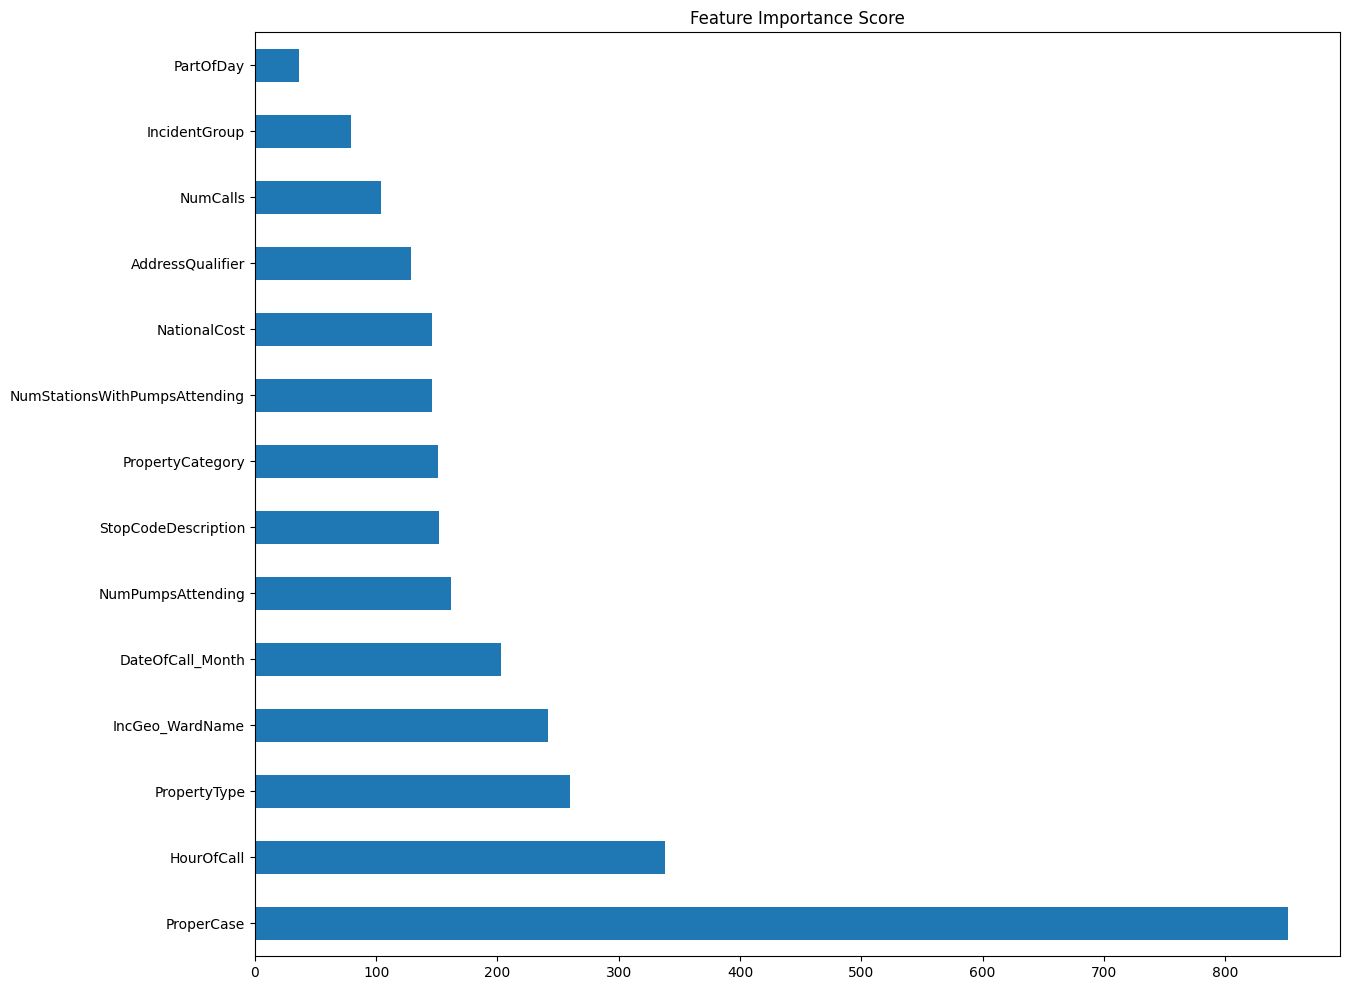

In [18]:
feature_imp(pipe._final_estimator, X_train[features_order])

## Save model

In [19]:
pickle_out = open('../api/pipe.pkl', 'wb')
pickle.dump(pipe, pickle_out)
pickle_out.close()